In [ ]:
# 环境设置和路径配置
import sys
import os

# 设置模型、数据和输出路径
model_path = '/home/jiacheng008/Py_mmWave_Roformer/rope_informer'
checkpoints = '/home/jiacheng008/Py_mmWave_Roformer/checkpoints/'
output_path = '/home/jiacheng008/Py_mmWave_Roformer/test_results/'

# 确保目录存在
os.makedirs(checkpoints, exist_ok=True)
os.makedirs(output_path, exist_ok=True)

# 将模型路径添加到sys.path
sys.path.append(os.path.dirname(model_path))

print("环境设置完成")

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# 导入必要的库
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import argparse
import matplotlib.pyplot as plt
%matplotlib inline

print("库导入完成")

ModuleNotFoundError: No module named 'torchvision'

In [5]:
# 数据路径定义和类别映射
data_paths = {
    "stationary": {
        "xoz": "/home/jiacheng008/Py_mmWave_Roformer/Dataset/stationary.test/pHistBytes_clustered_voxel/pHistBytes_clustered_voxel_XOZ",
        "yoz": "/home/jiacheng008/Py_mmWave_Roformer/Dataset/stationary.test/pHistBytes_clustered_voxel/pHistBytes_clustered_voxel_YOZ"
    },
    "run": {
        "xoz": "/home/jiacheng008/Py_mmWave_Roformer/Dataset/run.test/pHistBytes_clustered_voxel/pHistBytes_clustered_voxel_XOZ",
        "yoz": "/home/jiacheng008/Py_mmWave_Roformer/Dataset/run.test/pHistBytes_clustered_voxel/pHistBytes_clustered_voxel_YOZ"
    },
    "squat": {
        "xoz": "/home/jiacheng008/Py_mmWave_Roformer/Dataset/squat.test/pHistBytes_clustered_voxel/pHistBytes_clustered_voxel_XOZ",
        "yoz": "/home/jiacheng008/Py_mmWave_Roformer/Dataset/squat.test/pHistBytes_clustered_voxel/pHistBytes_clustered_voxel_YOZ"
    },
    "stand": {
        "xoz": "/home/jiacheng008/Py_mmWave_Roformer/Dataset/stand.test/pHistBytes_clustered_voxel/pHistBytes_clustered_voxel_XOZ",
        "yoz": "/home/jiacheng008/Py_mmWave_Roformer/Dataset/stand.test/pHistBytes_clustered_voxel/pHistBytes_clustered_voxel_YOZ"
    },
    "walk": {
        "xoz": "/home/jiacheng008/Py_mmWave_Roformer/Dataset/walk.test/pHistBytes_clustered_voxel/pHistBytes_clustered_voxel_XOZ",
        "yoz": "/home/jiacheng008/Py_mmWave_Roformer/Dataset/walk.test/pHistBytes_clustered_voxel/pHistBytes_clustered_voxel_YOZ"
    }
}

# 行为类别映射
behavior_mapping = {
    "stationary": 0,
    "run": 1,
    "squat": 2,
    "stand": 3,
    "walk": 4
}

# 图像尺寸定义
image_sizes = {
    "xoz": (25, 25),  # XOZ视角图像尺寸
    "yoz": (25, 15)   # YOZ视角图像尺寸
}

print("数据路径和类别定义完成")

数据路径和类别定义完成


In [6]:
# 自定义数据集类（支持滑窗）
class BehaviorDataset(Dataset):
    def __init__(self, data_paths, window_size=3, seq_len=15000, is_train=True):
        self.window_size = window_size
        self.seq_len = seq_len
        self.data = []
        self.labels = []

        # 收集所有图像路径和标签
        for behavior, paths in data_paths.items():
            label = behavior_mapping[behavior]

            # 处理XOZ视角
            xoz_path = paths["xoz"]
            if os.path.exists(xoz_path):
                xoz_images = []
                for img_name in sorted(os.listdir(xoz_path)):
                    if img_name.endswith(('.png', '.jpg', '.jpeg')):
                        xoz_images.append(os.path.join(xoz_path, img_name))

                # 为XOZ视角创建滑窗样本
                for i in range(len(xoz_images) - window_size + 1):
                    self.data.append((xoz_images[i:i+window_size], label, "xoz"))

            # 处理YOZ视角
            yoz_path = paths["yoz"]
            if os.path.exists(yoz_path):
                yoz_images = []
                for img_name in sorted(os.listdir(yoz_path)):
                    if img_name.endswith(('.png', '.jpg', '.jpeg')):
                        yoz_images.append(os.path.join(yoz_path, img_name))

                # 为YOZ视角创建滑窗样本
                for i in range(len(yoz_images) - window_size + 1):
                    self.data.append((yoz_images[i:i+window_size], label, "yoz"))

        # 划分训练集和测试集
        train_data, test_data = train_test_split(
            self.data, test_size=0.2, random_state=42, stratify=[d[1] for d in self.data]
        )

        self.data = train_data if is_train else test_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_paths, label, view = self.data[idx]
        window_images = []

        # 加载窗口内的所有图像
        for img_path in img_paths:
            img = Image.open(img_path).convert('L')  # 转换为灰度图

            # 根据视角调整图像大小
            if view == "xoz":
                img = img.resize(image_sizes["xoz"])
            else:
                img = img.resize(image_sizes["yoz"])

            # 转换为numpy数组并展平
            img_array = np.array(img).flatten()
            window_images.append(img_array)

        # 将窗口内的所有图像拼接成一个序列
        sequence = np.concatenate(window_images)

        # 如果序列长度不够，进行填充
        if len(sequence) < self.seq_len:
            pad_width = self.seq_len - len(sequence)
            sequence = np.pad(sequence, (0, pad_width), mode='constant')
        # 如果序列过长，进行截断
        elif len(sequence) > self.seq_len:
            sequence = sequence[:self.seq_len]

        return torch.FloatTensor(sequence), torch.tensor(label, dtype=torch.long)

print("自定义数据集类定义完成")

自定义数据集类定义完成


In [7]:
# 创建数据加载器
# 计算序列长度：每个样本包含3帧，每帧图像展平后的长度
# XOZ: 25*25 = 625, YOZ: 25*15 = 375
# 总序列长度 = 3 * (625 + 375) = 3000
seq_len = 3000

train_dataset = BehaviorDataset(data_paths, window_size=3, seq_len=seq_len, is_train=True)
test_dataset = BehaviorDataset(data_paths, window_size=3, seq_len=seq_len, is_train=False)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"训练集大小: {len(train_dataset)}")
print(f"测试集大小: {len(test_dataset)}")
print("数据加载器创建完成")

训练集大小: 1312
测试集大小: 328
数据加载器创建完成


In [8]:
# 参数设置
class Args:
    def __init__(self):
        self.model = 'informer'
        self.data = 'Classification'
        self.root_path = ''
        self.enc_in = 1
        self.d_model = 64
        self.d_ff = 256
        self.train_epochs = 20
        self.batch_size = 8
        self.seq_len = seq_len  # 使用计算得到的序列长度
        self.output_path = output_path
        self.checkpoints = checkpoints
        self.test_ratio = 0.2
        self.n_heads = 8
        self.has_rope = True
        self.features = 'M'
        self.target = 'OT'
        self.freq = 'h'
        self.label_len = 48
        self.pred_len = 24
        self.dec_in = 1
        self.c_out = 5  # 5种行为分类
        self.e_layers = 2
        self.d_layers = 1
        self.s_layers = '3,2,1'
        self.factor = 5
        self.padding = 0
        self.distil = True
        self.dropout = 0.05
        self.attn = 'prob'
        self.embed = 'timeF'
        self.activation = 'gelu'
        self.output_attention = False
        self.do_predict = False
        self.mix = True
        self.cols = None
        self.num_workers = 0
        self.itr = 1
        self.patience = 2
        self.learning_rate = 0.0001
        self.des = 'test'
        self.loss = 'mse'
        self.lradj = 'type1'
        self.use_amp = False
        self.inverse = False
        self.use_gpu = True if torch.cuda.is_available() else False
        self.gpu = 0
        self.use_multi_gpu = False
        self.devices = '0,1,2,3'

args = Args()

print("参数设置完成")

参数设置完成


In [9]:
# 导入模型并设置实验
from rope_informer import Exp_Informer

# 修改Exp_Informer类以使用新的数据加载器
class CustomExp_Informer(Exp_Informer):
    def _get_data(self, flag):
        if flag == 'test':
            return test_dataset, test_loader
        else:
            return train_dataset, train_loader

# 设置实验
setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(
    args.model, args.data, args.features,
    args.seq_len, args.label_len, args.pred_len,
    args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor,
    args.embed, args.distil, args.mix, args.des, 1)

exp = CustomExp_Informer(args)  # 使用自定义的实验类

print("模型导入和实验设置完成")

Use CPU
模型导入和实验设置完成


In [10]:
# 模型训练
print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
exp.train(setting)

print("模型训练完成")

>>>>>>>start training : informer_Classification_ftM_sl3000_ll48_pl24_dm64_nh8_el2_dl1_df256_atprob_fc5_ebtimeF_dtTrue_mxTrue_test_1>>>>>>>>>>>>>>>>>>>>>>>>>>
	iters: 100, epoch: 1 | loss: 0.7796736
	speed: 0.3143s/iter; left time: 999.7742s
Epoch: 1 cost time: 52.17405915260315


KeyboardInterrupt: 

In [28]:
# 模型测试
print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
exp.test(setting)

torch.cuda.empty_cache()

print("模型测试完成")

>>>>>>>testing : informer_Classification_ftM_sl3000_ll48_pl24_dm64_nh8_el2_dl1_df256_atprob_fc5_ebtimeF_dtTrue_mxTrue_test_1<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
test shape: torch.Size([328, 10]) torch.Size([328])
accuracy:0.7682926829268293
模型测试完成


总体准确率: 0.7683


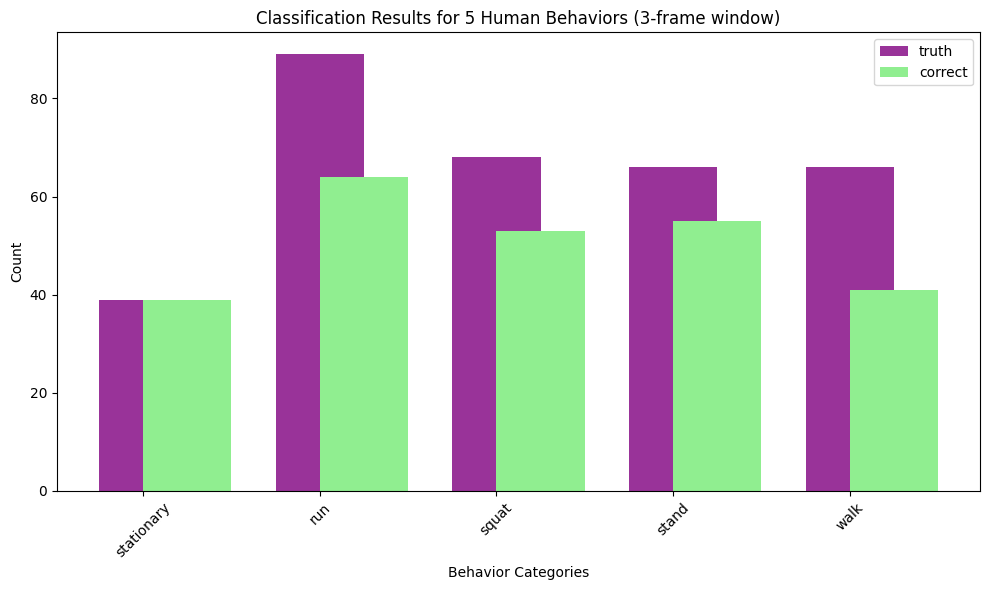

结果可视化完成


In [29]:
# 结果可视化
truth = np.load(os.path.join(args.output_path, setting, "true.npy"))
preds = np.load(os.path.join(args.output_path, setting, "pred.npy"))

# 计算每个类别的总数和预测正确的数量
bin_counts = np.bincount(truth, minlength=5)
correct_counts = np.bincount(truth[preds == truth], minlength=5)

# 计算准确率
accuracy = np.sum(preds == truth) / len(truth)
print(f"总体准确率: {accuracy:.4f}")

# 绘制直方图
categories = ['stationary', 'run', 'squat', 'stand', 'walk']
plt.figure(figsize=(10, 6))
plt.bar(categories, bin_counts, width=0.5, align='center', alpha=0.8, label='truth', color='purple')
plt.bar(categories, correct_counts, width=0.5, align='edge', alpha=1.0, label='correct', color='lightgreen')
plt.xlabel('Behavior Categories')
plt.ylabel('Count')
plt.title('Classification Results for 5 Human Behaviors (3-frame window)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/home/jiacheng008/Py_mmWave_Roformer/behavior_classification_results_window.png')
plt.show()

print("结果可视化完成")

In [27]:
#!/usr/bin/env python3
import os
import sys

# 设置数据集基础路径
data_base_path = '/home/jiacheng008/Py_mmWave_Roformer/Dataset/'

# 行为类别
behaviors = ["stationary", "run", "squat", "stand", "walk"]
views = ["xoz", "yoz"]

print("验证数据集结构...")
print(f"基础路径: {data_base_path}")

for behavior in behaviors:
    print(f"\n检查行为: {behavior}")
    for view in views:
        # 构建路径
        path = os.path.join(
            data_base_path,
            f"{behavior}.test",
            "pHistBytes_clustered_voxel",
            f"pHistBytes_clustered_voxel_{view.upper()}"
        )

        print(f"  检查路径: {path}")

        if not os.path.exists(path):
            print(f"    → 路径不存在!")
            continue

        # 计算图像文件数量
        image_files = []
        for f in os.listdir(path):
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_files.append(f)

        print(f"    → 找到 {len(image_files)} 个图像文件")

        if image_files:
            print(f"    → 示例文件: {image_files[:3]}")

print("\n验证完成!")

验证数据集结构...
基础路径: /home/jiacheng008/Py_mmWave_Roformer/Dataset/

检查行为: stationary
  检查路径: /home/jiacheng008/Py_mmWave_Roformer/Dataset/stationary.test/pHistBytes_clustered_voxel/pHistBytes_clustered_voxel_XOZ
    → 找到 100 个图像文件
    → 示例文件: ['pHistBytes_79_XOZ.png', 'pHistBytes_73_XOZ.png', 'pHistBytes_70_XOZ.png']
  检查路径: /home/jiacheng008/Py_mmWave_Roformer/Dataset/stationary.test/pHistBytes_clustered_voxel/pHistBytes_clustered_voxel_YOZ
    → 找到 100 个图像文件
    → 示例文件: ['pHistBytes_66_YOZ.png', 'pHistBytes_32_YOZ.png', 'pHistBytes_51_YOZ.png']

检查行为: run
  检查路径: /home/jiacheng008/Py_mmWave_Roformer/Dataset/run.test/pHistBytes_clustered_voxel/pHistBytes_clustered_voxel_XOZ
    → 找到 225 个图像文件
    → 示例文件: ['pHistBytes_103_XOZ.png', 'pHistBytes_79_XOZ.png', 'pHistBytes_113_XOZ.png']
  检查路径: /home/jiacheng008/Py_mmWave_Roformer/Dataset/run.test/pHistBytes_clustered_voxel/pHistBytes_clustered_voxel_YOZ
    → 找到 225 个图像文件
    → 示例文件: ['pHistBytes_134_YOZ.png', 'pHistBytes_107_YOZ.png', 'pHistB